In [72]:
from fastai.vision.all import *
import albumentations
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Config

In [73]:
import os
# Check if running in a Kaggle environment
is_kaggle = False
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    is_kaggle = True
else:
    is_kaggle = False

is_kaggle

False

In [74]:
from pathlib import Path
Config = {
    'path': Path('./data') if not is_kaggle else Path('../input/paddy-disease-classification'), 
    'img_size': 224
}
Config['path']

Path('data')

In [75]:
! ls ./data

sample_submission.csv train.csv
test_images           train_images


## Data

In [76]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [77]:

def get_train_aug(): return albumentations.Compose([
            albumentations.RandomResizedCrop(Config['img_size'],Config['img_size']),
            albumentations.Transpose(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5),
            albumentations.CoarseDropout(p=0.5),
])

def get_valid_aug(): return albumentations.Compose([
    albumentations.CenterCrop(Config['img_size'],Config['img_size'], p=1.),
    albumentations.Resize(Config['img_size'],Config['img_size'])
], p=1)

tfms_train = [Resize(Config['img_size']), AlbumentationsTransform(get_train_aug())]
tfms_val =  [Resize(Config['img_size']), AlbumentationsTransform(get_valid_aug())]


In [78]:
dataset = ImageDataLoaders.from_folder(
    Config['path']/'train_images', 
    valid_pct=0.2, 
    item_tfms=Resize(Config['img_size'], method='Squish'), 
    batch_tfms=[*tfms_train, *tfms_val],
)

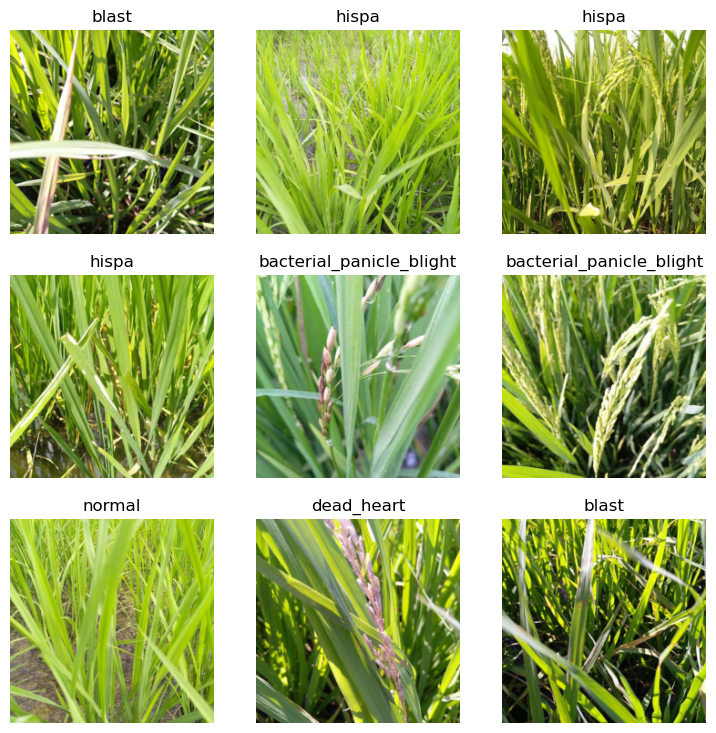

In [79]:
dataset.show_batch()

In [80]:
learner: Learner = vision_learner(dataset, 'resnet34', metrics=error_rate, path='.').to_fp16()

SuggestedLRs(valley=0.0008317637839354575, slide=0.002511886414140463)

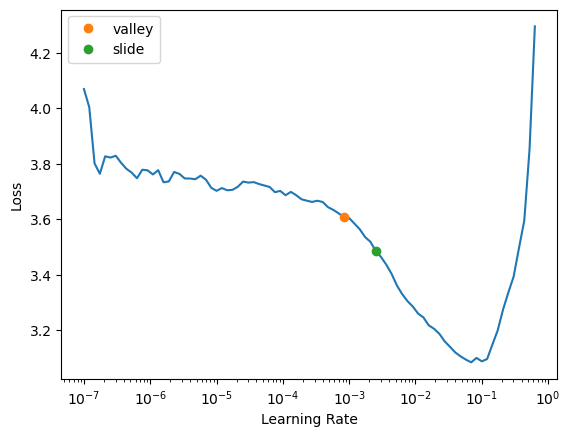

In [81]:
learner.lr_find(suggest_funcs=(valley, slide))

In [82]:
learner.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.941818,1.356634,0.433926,01:05


epoch,train_loss,valid_loss,error_rate,time
0,1.317752,0.983367,0.323402,01:24
1,1.093467,0.773857,0.257088,01:22
2,0.881122,0.727171,0.238827,01:28


In [88]:
preds, targs = learner.tta()

/Users/quankento/miniconda3/envs/torch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  f"User specified an unsupported autocast device_type '{self.device}'"
/Users/quankento/miniconda3/envs/torch/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [89]:
accuracy(preds, targs)

TensorBase(0.8006)

In [83]:
test_files = get_image_files(Config['path']/'test_images').sorted()
test_dls = dataset.test_dl(test_files)

In [84]:
preds, _, idxs = learner.get_preds(dl=test_dls, with_decoded=True)

In [85]:
mapping = dict(enumerate(dataset.vocab))
mapping

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [86]:

results = pd.Series(idxs.numpy(), name='idxs').map(mapping)
results

0           normal
1           normal
2            hispa
3            blast
4            blast
           ...    
3464    dead_heart
3465         hispa
3466        normal
3467         blast
3468    dead_heart
Name: idxs, Length: 3469, dtype: object

In [87]:
submission = pd.DataFrame({
    'image_id': sorted(os.listdir(Config['path']/'test_images')), 
    'label': results
})
submission.to_csv('submission1.csv', index=False)